# 基于频繁项集支持度的过滤组合概率选择算法（自设计）
## author：陈伟钊

# （一）Gurobi建模求得精确解

(a)假定机床是流水线作业，即某产品在机床1上加工完成后直接进入机床2加工，机床2加工完成后直接进入机床3，中间不可插入其它产品。确定产品的加工顺序，使在最短的时间内加工完全部产品.

In [2]:
import gurobipy as grb

# 不同产品在不同机器上的加工时间
machine_pro_time = [[40,5,34],
                    [60,33,50],
                    [52,25,20],
                    [35,21,10]]

# 定义这里的M为1000，相比于加工时间已足够大
M = 1000

In [3]:
m1 = grb.Model('solve1')

#下标
tl = [(1,2),(1,3),(1,4),
            (2,3),(2,4),
                  (3,4)]
y = m1.addVars(tl,vtype=grb.GRB.BINARY,name='y')

x = m1.addVars(range(1,5),range(1,4),lb=0,name='x')

# 目标变量
z = m1.addVar(lb=0,name='z')

# 更新变量环境
m1.update()

# 创建目标函数
m1.setObjective(z,sense=grb.GRB.MINIMIZE)

# 约束1
for i in range(1,5):
    for j in range(1,3):
        m1.addConstr(x[i,j] + machine_pro_time[i-1][j-1] <= x[i,j+1],name='same_product_order')

# 约束2
for j in range(1,4):
    for i in range(1,4):
        for I in range(i+1,5):
            m1.addConstr(x[i,j] + machine_pro_time[i-1][j-1] <= x[I,j] + M*(1-y[i,I]),name='different_product_order')
            m1.addConstr(x[I,j] + machine_pro_time[I-1][j-1] <= x[i,j] + M*y[i,I],name='different_product_order')

# 约束3
for i in range(1,5):
    m1.addConstr(z >= x[i,3] + machine_pro_time[i-1][2],name='z')

# 执行线性规划模型
m1.optimize()
print("Obj:", m1.objVal)
for v in m1.getVars():
    print(f"{v.varName}：{round(v.x,3)}")

Using license file C:\Users\86131\gurobi.lic
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 48 rows, 19 columns and 132 nonzeros
Model fingerprint: 0x9dd5ed9d
Variable types: 13 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+00, 1e+03]
Presolve time: 0.00s
Presolved: 48 rows, 19 columns, 132 nonzeros
Variable types: 13 continuous, 6 integer (6 binary)

Root relaxation: objective 1.430000e+02, 6 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  143.00000    0    6          -  143.00000      -     -    0s
H    0     0                     264.0000000  143.00000  45.8%     -    0s
H    0     0                     2

可知此时Flow_Shop问题的加工顺序为2->1->3->4

(b)假定机床不是流水作业，但需保证每件产品在机床1、2、3上按先后次序加工。确定产品的加工顺序，使在最短的时间内加工完全部产品

In [4]:
m2 = grb.Model('solve2')

#下标
tl2 = []
for j in range(1,4):
    index = [(1,2,j),(1,3,j),(1,4,j),
                     (2,3,j),(2,4,j),
                             (3,4,j)]
    tl2.extend(index)
Y = m2.addVars(tl2,vtype=grb.GRB.BINARY,name='Y')

X = m2.addVars(range(1,5),range(1,4),lb=0,name='X')

# 目标变量
Z = m2.addVar(lb=0,name='Z')

# 更新变量环境
m2.update()

# 创建目标函数
m2.setObjective(Z,sense=grb.GRB.MINIMIZE)

# 约束3
for i in range(1,5):
    m2.addConstr(Z >= X[i,3] + machine_pro_time[i-1][2],name='Z')

# 约束1
for i in range(1,5):
    for j in range(1,3):
        m2.addConstr(X[i,j] + machine_pro_time[i-1][j-1] <= X[i,j+1],name='Same_product_order')
        
# 约束2
for j in range(1,4):
    for i in range(1,4):
        for I in range(i+1,5):
            m2.addConstr(X[i,j] + machine_pro_time[i-1][j-1] <= X[I,j] + M*(1-Y[i,I,j]),name='Different_product_order')
            m2.addConstr(X[I,j] + machine_pro_time[I-1][j-1] <= X[i,j] + M*Y[i,I,j],name='Different_product_order')

# 执行线性规划模型
m2.optimize()
print("Obj:", m2.objVal)
for v in m2.getVars():
    print(f"{v.varName}：{round(v.x,3)}")

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 48 rows, 31 columns and 132 nonzeros
Model fingerprint: 0x0fd8aab7
Variable types: 13 continuous, 18 integer (18 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+00, 1e+03]
Found heuristic solution: objective 270.0000000
Presolve time: 0.00s
Presolved: 48 rows, 31 columns, 132 nonzeros
Variable types: 13 continuous, 18 integer (18 binary)

Root relaxation: objective 1.430000e+02, 15 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  157.00000    0    7  270.00000  157.00000  41.9%     -    0s
H    0     0                     232.0000000  157.00000  32.3%     -    0s
     0     0  191.00000   

可知此时Job_Shop问题在三台机器上的加工顺序都为2->3->1->4.

# （二）启发式算法求满意解

对于m台机器、n个产品的大规模问题，使用建模求得精确解往往不太现实。此处自己设计了一个“基于频繁项集支持度的过滤组合概率选择算法”，并使用Python实现。此处由于问题规模较小，使用该启发式算法经过少次迭代也得到该问题的最优解。

<br/>
首先，在我的算法中结合了机器学习中的几个概念——余弦相似度、频繁项集和支持度。
<br/>
余弦相似度：对于n个产品，如果说在两台不同的机器上，产品的加工时间总体接近，当其相似度达到一个阈值时（在算法中可控制），可近似将两台机器视为一台机器（极端情况两台机器对所有产品加工时间都相同）。比如说当有4台机器时，其中机器1和2对产品加工时间的相似度为0.99,机器3和4的相似度为0.98，都超过该阈值，那么我们此处就只需考虑2和3之间的排程，因为1和2之间，3和4之间的产品等待时间的优化空间不大，从而降低了问题的求解规模。而对于相似度没达到阈值的“相邻”两台机器，通过使用2*n的排程精确算法得到所有可能的初始排程方案，空间复杂度为O(knlogn)，其中k由阈值参数控制，最大不会超过n。
<br/>
频繁项集：根据余弦相似度对机器数进行协同过滤，再利用2*n的排程精确算法（本质是一个排序算法），此处即可得到初始可供选择的排程方案。举个例子，假设初始只有2个排程方案，其中方案1的产品加工顺序方案为（1,2,3,4），方案2的产品加工顺序方案为（1,2,4,3），则此处我们可以得到频繁项（1），（1，2）的支持度为2，由于其在两个方案都出现了；而频繁项（2,3）、（1,2,3）、（1,2,4,3）等的支持度为1。此处的启发规则有点类似群智能，当某部分产品加工顺序的出现频率高，那么相应地其在最终最优解的出现频率相对会高。
<br/>
支持度：上述的支持度仅从频率的角度出发，但也得考虑整个频繁项的大小，也就是加工时间的大小。因此最终的支持度除了频率之外，还考虑了相应频繁项在所有机器上的最后完工时间，从而修正了支持度（当确定了频繁项，相应的最后完工时间仅需作m*n次比较即可得到）。根据修正过后的支持度大小，将其映射为选择概率的大小。比如说上述频繁项（1,2,3,4）的频率为1，完工时间为216；频繁项（1,2,4,3）的频率为1，完工时间为300；那么相应的频繁项（1,2,3,4）支持度为216，频繁项（1,2,4,3）支持度为300，此处的支持度是越小越好的，也就说最后频繁项（1,2,3,4）的选择概率可能为0.04，频繁项（1,2,4,3）为0.01，两者有个选择概率上的区别；此外还有其他频繁项，包括（1）、（1,2）等等，此处算法支持度定义为频率*完工时间，支持度越小越好，相应地转换成选择概率。
<br/>
<br/>
<br/>
<br/>
其次，介绍算法的迭代方案和迭代终止条件。
<br/>
迭代方案：根据支持度转换后的选择概率大小，每次从频繁项集中随机挑选n个频繁项（作判断是否包含所有产品），再根据选择的顺序形成一个新的排程方案；如果说该新方案的最终完成时间比初始化的最佳排程方案完成时间少，该进行迭代。
<br/>
迭代终止条件：可根据迭代次数、迭代时间进行限制，但当问题规模不确定时，较难确定该参数。此处根据迭代效果进行判断，如果说迭代m次后效果无改进，则停止；有改进的话则从0继续开始计数。
<br/>
<br/>
<br/>
<br/>
该算法可能比较适合于大规模的排程问题，并且参数可控。以下是该算法的思路和实现代码。
<br/>
第一步，根据产品的加工时间计算余弦相似度进行协同过滤
<br/>
第二步，利用2*n的排程算法（排序算法）确定初始的可能排程方案
<br/>
第三步，初始化
<br/>
第四步，构造频繁项集表和相应的选择概率表
<br/>
第五步，根据选择概率对频繁项集进行组合选择
<br/>
第六步，比较，若满足解的改进条件则进行改进，同时判断是否满足迭代终止条件，若尚未满足，则转到第五步
<br/>
第七步，迭代停止，得到满意解

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl    

mpl.rcParams['font.sans-serif'] = ['SimHei']  #指定默认字体
mpl.rcParams['axes.unicode_minus'] = False   #正常显示图像中的负号

import warnings
warnings.filterwarnings("ignore")

In [6]:
# 定义基于余弦相似度的过滤函数
# 传入参数1为机器对每个产品的加工时间；传入参数2为过滤基准，默认为0.9，即如果两台机器对产品的加工时间的余弦相似度达到0.9，视为一台机器系统
def cos(machine_product_pro_time,filter_value=0.9):
    set_save = set()
    for i in range(len(machine_product_pro_time)-1): 
        a_norm = np.linalg.norm(machine_product_pro_time[i])
        b_norm = np.linalg.norm(machine_product_pro_time[i+1])
        result = np.dot(machine_product_pro_time[i],machine_product_pro_time[i+1])/(a_norm*b_norm)
        if result <= filter_value:
            set_save.update([i+1,i+2]) # 下标从1开始
    return set_save


# 定义两两排序的精确算法函数，得到两台机器n个产品的最佳加工顺序
def sort_part(cos_result,machine_product_pro_time):
    list_save_round = []                                 # 储存所有的两两排序的最佳加工顺序
    for i in range(len(cos_result)-1):                   # 总共要进行len(cos_result)-1次的两两排序
        part_cos_result = cos_result[i:i+2]              # i为第一台机器，i+1为第二台机器
        dict1 = {}
        for i in part_cos_result:
            for j in range(len(machine_product_pro_time[0])):
                dict1[(i,j+1)] = machine_product_pro_time[i-1][j]
        # print(dict1)

        list_save_head = []
        list_save_tail = []

        while len(dict1)>0:                                 # 上述最后一步的i为第二台机器
            search_val = min(dict1, key=dict1.get)
            if search_val[0] == i:
                list_save_tail.insert(0,search_val[1])
                dict1.pop((i,search_val[1]))
                dict1.pop((i-1,search_val[1]))
            else:
                list_save_head.append(search_val[1])
                dict1.pop((i,search_val[1]))
                dict1.pop((i-1,search_val[1]))

        list_save_head.extend(list_save_tail)
        list_save_round.append(list_save_head)
    return list_save_round


# 定义计算频繁项集的函数
def freq_count(list_save_round):
    dict2 = {}

    # 只有单个工序的频繁项集
    for i in range(1,len(list_save_round[0])+1):
        dict2[(i,)] = len(list_save_round)
    # 所有工序的频繁项集
    for i in range(len(list_save_round)):
        dict2[tuple(list_save_round[i])] = 1

    # 其他情况的频繁项集
    for i in range(len(list_save_round)):
        for j in range(2,len(list_save_round[i])):       # 项集长度
            for k in range(len(list_save_round[i])+1-j):
                if tuple(list_save_round[i][k:k+j]) in dict2.keys():
                    dict2[tuple(list_save_round[i][k:k+j])] += 1
                else:
                    dict2[tuple(list_save_round[i][k:k+j])] = 1
    return dict2


# 定义获取频繁项集用时的函数
def freq_time(list_save_route,product_machine_pro_time):
    dict3 = {}
    for i in list_save_route.keys():
        list_save_route_part = list(i)
        if len(list_save_route_part) == 1:            #说明只有1道工序
            dict3[i] = product_machine_pro_time[i[0]-1].sum()
        else:
            list_save_pro_time_part = []

            for j in list_save_route_part:
                list_save_pro_time_part.append(list(product_machine_pro_time[j-1]))

            list_save_pro_time_part[0] = list(np.cumsum(list_save_pro_time_part[0]))
            for k in range(1,len(list_save_pro_time_part)):
                list_save_pro_time_part[k][0] = list_save_pro_time_part[k-1][0] + list_save_pro_time_part[k][0]
                for m in range(1,len(list_save_pro_time_part[k])):
                    list_save_pro_time_part[k][m] = max(list_save_pro_time_part[k-1][m],list_save_pro_time_part[k][m-1]) + list_save_pro_time_part[k][m]

            dict3[i] = list_save_pro_time_part[-1][-1]
    return dict3


# 定义概率转换函数
def list_save_route_chance(list_save_route_result):
    index_max = max([k for k in list_save_route_result.values()])
    index_std = np.std([k for k in list_save_route_result.values()])
    list_save_route_result_final = {}
    for i,j in list_save_route_result.items():
        list_save_route_result_final[i] = index_max + index_std - j # 值越小，选择的可能性应该越大
    
    index_sum = sum([k for k in list_save_route_result_final.values()])
    for i,j in list_save_route_result_final.items():
        list_save_route_result_final[i] = j/index_sum               # 映射到[0,1]的概率区间上
    return list_save_route_result_final

最佳加工工序为： [(1, 2, 3, 4)]
对应加工时间为： 218


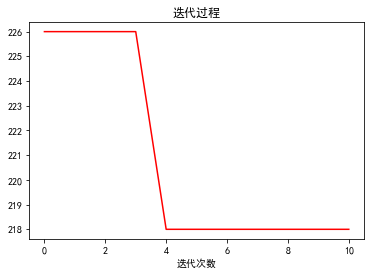

In [8]:
if __name__ == '__main__':
    # 输入参数一为产品在各个机器上的加工时间
    product_machine_pro_time = np.array([[40,5,34],
                            [60,33,50],
                            [52,25,20],
                            [35,21,10]])
    machine_product_pro_time = product_machine_pro_time.T
    
    # 输入参数二为机器产品的匹配属性过滤参数
    # 使用上面自定义的计算余弦相似度的函数
    # 将字典再转为列表，确保机器有序，即按照机器1->2->3...->n的流水线流程工作
    cos_result = cos(machine_product_pro_time,filter_value=0.95)
    cos_result = list(cos_result)
    cos_result.sort()
    
    # 使用上面自定义的两两排序的精确算法函数
    list_save_round = sort_part(cos_result,machine_product_pro_time)
    
    # 使用上面自定义的频繁项集计数函数
    list_save_route = freq_count(list_save_round)
    
    # 使用上面自定义的频繁项计时函数
    list_save_route_part2 = freq_time(list_save_route,product_machine_pro_time)
    
    # 根据路径长度和频繁项集的乘积大小决定选择概率，乘积越小，选择概率则越大
    list_save_route_result = list_save_route
    for i in list_save_route_result.keys():
        list_save_route_result[i] = list_save_route[i] * list_save_route_part2[i]
        
    # 使用上面自定义的概率转换函数
    list_save_route_result_final = list_save_route_chance(list_save_route_result)
    
    # 初始化
    # 在频繁项集里随机选择一个具有全部工序的项集
    for i,j in list_save_route_part2.items():
        if len(i) == len(machine_product_pro_time[0]):
            best_route = i
            best_val = j
            break

    # 迭代停止条件
    # 当连续迭代超过n次后，best_val值无变化，则说明当前方案为最优。
    n = 5                                        # 可根据问题规模设置，这里设为5
    counter = 0                                  # 记录每次变化后的无变化次数
    list_history = []                            # 记录历史迭代的值
    while counter <= n: 
        list_save_route_diedai = []
        while len(list_save_route_diedai) < 4:   # 保证所有产品都参与排序

            chance_try = np.random.choice([i for i in list_save_route_part2.keys()],
                                          size=4,
                                          replace=False,
                                          p=[k for k in list_save_route_result_final.values()])


            list_save_route_diedai = []
            for item in chance_try:
                for node in item:
                    if len(list_save_route_diedai) >= 4:
                        break
                    else:
                        if node not in list_save_route_diedai:
                            list_save_route_diedai.append(node)
                        else:
                            pass

        dict_save_route_diedai = {}
        dict_save_route_diedai[tuple(list_save_route_diedai)] = 0
        dict_route_diedai = freq_time(dict_save_route_diedai,product_machine_pro_time)
        if dict_route_diedai[tuple(list_save_route_diedai)] < best_val:
            counter = 0
            best_route = dict_route_diedai.keys()
            best_val = dict_route_diedai[tuple(list_save_route_diedai)]
            list_history.append(best_val)        
        else:
            counter += 1
            list_history.append(best_val)

    print('最佳加工工序为：',list(best_route))
    print('对应加工时间为：',best_val)

    # 迭代过程可视化
    plt.plot(list_history,color='r')
    plt.title('迭代过程')
    plt.xlabel('迭代次数')
    plt.show()

发现通过上述算法，也可在有限次数内得到该问题的最优解或满意解。